<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#LLCOMP" data-toc-modified-id="LLCOMP-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>LLCOMP</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Config" data-toc-modified-id="Config-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#LLMGP" data-toc-modified-id="LLMGP-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>LLMGP</a></span><ul class="toc-item"><li><span><a href="#Config" data-toc-modified-id="Config-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Run</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Summary</a></span></li></ul></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Re-profile the curatedMetagenomics dataset with the GTDB-r202 Struo2 mg-profiling databases

# Var

In [25]:
base_dir = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/'
work_dir = file.path(base_dir, 'combined_GTDBr202')
reads_dir = file.path(base_dir, 'LLMGQC')
scratch_dir = '/ebio/abt3_scratch/nyoungblut/curatedMetagenomics/'

data_dir = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/combined_GTDBr86/profiles/kraken/'
meta_file = file.path(data_dir, 'Global_metagenomes_Metadata.csv')

# Init

In [3]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(tidytable)
library(LeyLabRMisc)

In [4]:
df.dims()
setDTthreads(4)

# Load

In [50]:
# sample metadata
meta = Fread(meta_file) %>%
    mutate.(Sample = gsub('[.+-]+', '_', Sample)) %>%
    filter.(!is.na(non_westernized)) %>%
    mutate.(westernized = non_westernized == 'no') %>%
    select.(-non_westernized)
meta

dataset_name,Sample,subjectID,disease,age,gender,country,BMI,alcohol,disease_subtype,⋯,systolic_p,creatine,albumine,bilubirin,smoker,ever_smoker,birth_control_pil,c_peptide,insulin_cat,westernized
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>
AsnicarF_2017,MV_FEM1_t1Q14,MV_FEM1,healthy,NA,female,ITA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,TRUE
AsnicarF_2017,MV_FEM2_t1Q14,MV_FEM2,healthy,NA,female,ITA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ZeeviD_2015,PNP_Validation_45,PNP_Validation_45,healthy,NA,NA,ISR,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,TRUE
ZeeviD_2015,PNP_Validation_46,PNP_Validation_46,healthy,NA,NA,ISR,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,TRUE


# LLCOMP

* uncompress read files

In [7]:
# compressed read files
spring_files = list_files(reads_dir, 'samples_spring.txt')
spring_files %>% unique_n('files')
spring_files %>% head(n=3)

No. of unique files: 33 


[1] "/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes//LLMGQC/01_CosteaPI_2017/final/samples_spring.txt"      
[2] "/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes//LLMGQC/02_Obregon-TitoAJ_2015/final/samples_spring.txt"
[3] "/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes//LLMGQC/03_PasolliE_2018/final/samples_spring.txt"

In [12]:
# loading & merging tables
read_tbl = function(F){
    df = Fread(F, fill=TRUE)
    df$Dataset = F %>% dirname %>% dirname %>% basename
    return(df)
}

spring = spring_files %>%
    lapply(read_tbl) %>%
    rbindlist(use.names=TRUE) %>%
    select.(-Notes)
spring

Sample,Reads,Dataset
<chr>,<chr>,<chr>
halbarad-11-0-0,/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/LLMGQC/01_CosteaPI_2017/final/halbarad-11-0-0/R1_final.spring,01_CosteaPI_2017
scavenger-11-60-0,/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/LLMGQC/01_CosteaPI_2017/final/scavenger-11-60-0/R1_final.spring,01_CosteaPI_2017
⋮,⋮,⋮
SZAXPI017591-140,/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/LLMGQC/33_YuJ_2015/final/SZAXPI017591-140/R1_final.spring,33_YuJ_2015
SZAXPI017592-142,/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/LLMGQC/33_YuJ_2015/final/SZAXPI017592-142/R1_final.spring,33_YuJ_2015


In [14]:
F = file.path(scratch_dir, 'samples_spring.tsv')
spring %>% write_table(F)

File written: /ebio/abt3_scratch/nyoungblut/curatedMetagenomics//samples_spring.tsv 


### Config

In [17]:
cat_file(file.path(scratch_dir, 'config.yaml'))

# Input table with sample <-> read_file information
samples_file: /ebio/abt3_scratch/nyoungblut/curatedMetagenomics/samples_spring.tsv

# Output location (can be the same as input)
output_dir: /ebio/abt3_scratch/nyoungblut/curatedMetagenomics/LLMGQC/

# temporary file directory (your username will be added automatically)
tmp_dir: /ebio/abt3_scratch/

# If input are *.spring, are they paired-end reads (or single)?
spring_files_paired: False

# Remove input read files?
rm_input_reads: False

# ionice for reducing I/O loads (use "-c 2" for normal usage)
ionice: -c 3

# pipeline params
pipeline:
  snakemake_folder: ./
  script_folder: ./bin/scripts/
  name: LLCOMP

### Run

```
(snakemake) @ rick:/ebio/abt3_projects/software/dev/ll_pipelines/llcomp
$ screen -L -S llcomp-curMG ./snakemake_sge.sh /ebio/abt3_scratch/nyoungblut/curatedMetagenomics/config.yaml 40 -F
```

## LLMGP

### Config

In [18]:
F = file.path(work_dir, 'LLMGP', 'config.yaml')
cat_file(F)

# DESCRIPTION:
## This is an example of running the pipeline with a custom humann2 db.
## This config is set up to just use the custom nucleotide db, but the protein db could be used also (or instead)

#-- I/O --#
# table with sample --> read_file information
samples_file: /ebio/abt3_scratch/nyoungblut/curatedMetagenomics/LLMGQC/samples.txt

# output location
output_dir: /ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/combined_GTDBr202/LLMGP/

# temporary file directory (your username will be added automatically)
tmp_dir: /ebio/abt3_scratch/

# read file path
# use "None" if full file path is included in the samples_file
read_file_path: None

#-- DB --#
# NOTE: the humann & kraken databases were built from the GTDB
## humann3
humann3_dbs:
  metaphlan3_mpa_db: /ebio/abt3_projects/databases_no-backup/metaphlan3/201901/mpa_v30_CHOCOPhlAn_201901_marker_info.txt
  nuc_db: /ebio/abt3_projects/databases_no-backup/GTDB/release202/Struo2/humann3/uniref50/genome

### Run

```
(snakemake) @ rick:/ebio/abt3_projects/software/dev/ll_pipelines/llmgp
$ screen -L -S llmgp-GTDBr202 ./snakemake_sge.sh /ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/combined_GTDBr202/LLMGP/config.yaml 50 -F
```

### Summary

In [59]:
F = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/combined_GTDBr86/profiles/kraken'
uncls_r86 = Fread(file.path(F, 'all-combined_kraken-unclassified.tsv')) %>%
    mutate.(database = 'Release 86',
            perc_mapped = 100 - percent_reads)
uncls_r86

sample,percent_reads,num_reads_mapped_to_clade,num_reads_mapped_to_taxon,rank_code,taxID,scientific_name,database,perc_mapped
<chr>,<dbl>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>
SAMEA5814677,68.88,24213714,24213714,U,0,unclassified,Release 86,31.12
SAMEA5814637,16.49,4989740,4989740,U,0,unclassified,Release 86,83.51
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
VTS_SS_7_4_18,25.42,635964,635964,U,0,unclassified,Release 86,74.58
VTS_SS_9_1_18,25.02,644572,644572,U,0,unclassified,Release 86,74.98


In [60]:
F = file.path(work_dir, 'LLMGP', 'kraken', 'all-combined_kraken-unclassified.tsv')
uncls_r202 = Fread(F) %>%
    mutate.(database = 'Release 202',
            perc_mapped = 100 - percent_reads)
uncls_r202

sample,percent_reads,num_reads_mapped_to_clade,num_reads_mapped_to_taxon,rank_code,taxID,scientific_name,database,perc_mapped
<chr>,<dbl>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>
halbarad-11-0-0,10.66,106586,106586,U,0,unclassified,Release 202,89.34
scavenger-11-60-0,7.83,78287,78287,U,0,unclassified,Release 202,92.17
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
SZAXPI017591-140,13.89,138851,138851,U,0,unclassified,Release 202,86.11
SZAXPI017592-142,11.63,116335,116335,U,0,unclassified,Release 202,88.37


In [61]:
# merging
uncls = rbindlist(list(uncls_r86, uncls_r202), use.names=TRUE) %>%
    mutate.(sample = gsub('[.+-]+', '_', sample)) 
uncls

sample,percent_reads,num_reads_mapped_to_clade,num_reads_mapped_to_taxon,rank_code,taxID,scientific_name,database,perc_mapped
<chr>,<dbl>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>
SAMEA5814677,68.88,24213714,24213714,U,0,unclassified,Release 86,31.12
SAMEA5814637,16.49,4989740,4989740,U,0,unclassified,Release 86,83.51
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
SZAXPI017591_140,13.89,138851,138851,U,0,unclassified,Release 202,86.11
SZAXPI017592_142,11.63,116335,116335,U,0,unclassified,Release 202,88.37


In [62]:
overlap(meta$Sample, uncls$sample)
uncls = uncls %>%
    inner_join.(meta, c('sample'='Sample'))
uncls

intersect(x,y): 3469 
setdiff(x,y): 0 
setdiff(y,x): 2494 
union(x,y): 5963 


sample,percent_reads,num_reads_mapped_to_clade,num_reads_mapped_to_taxon,rank_code,taxID,scientific_name,database,perc_mapped,dataset_name,⋯,systolic_p,creatine,albumine,bilubirin,smoker,ever_smoker,birth_control_pil,c_peptide,insulin_cat,westernized
<chr>,<dbl>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>
MV_FEM1_t1Q14,37.19,4967298,4967298,U,0,unclassified,Release 86,62.81,AsnicarF_2017,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,TRUE
MV_FEM1_t1Q14,8.74,87382,87382,U,0,unclassified,Release 202,91.26,AsnicarF_2017,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
PNP_Validation_46,39.10,10148667,10148667,U,0,unclassified,Release 86,60.90,ZeeviD_2015,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,TRUE
PNP_Validation_46,9.29,92917,92917,U,0,unclassified,Release 202,90.71,ZeeviD_2015,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,TRUE


In [63]:
# distributions
uncls %>%
    filter.(database == 'Release 86') %>%
    .$perc_mapped %>% summary_x
uncls %>%
    filter.(database == 'Release 202') %>%
    .$perc_mapped %>% summary_x

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
.,12.11,67.52,73.64,73.21318,79.84,98.61,29.184,11.914


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
.,19.19,85.81,88.21,87.47542,90.3,99.55,29.422,12.011


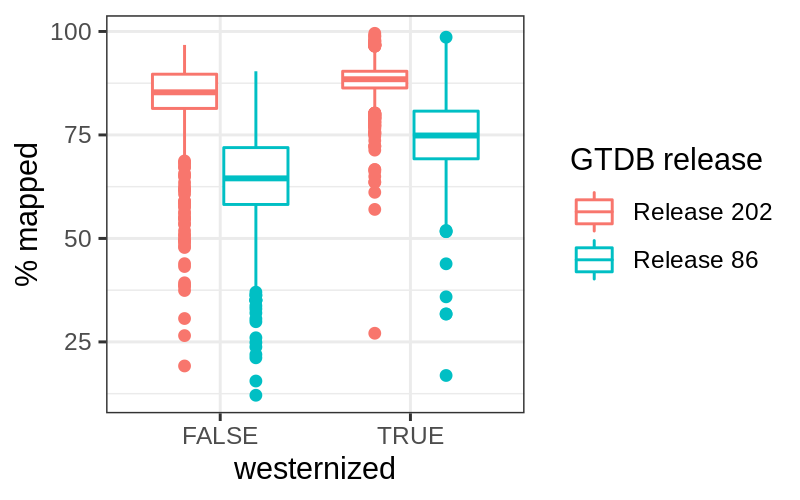

In [64]:
# summary
p = uncls %>%
    ggplot(aes(westernized, perc_mapped, color=database)) +
    geom_boxplot() +
    scale_color_discrete('GTDB release') +
    labs(y='% mapped') +
    theme_bw()
p.dims(4,2.5)
plot(p)

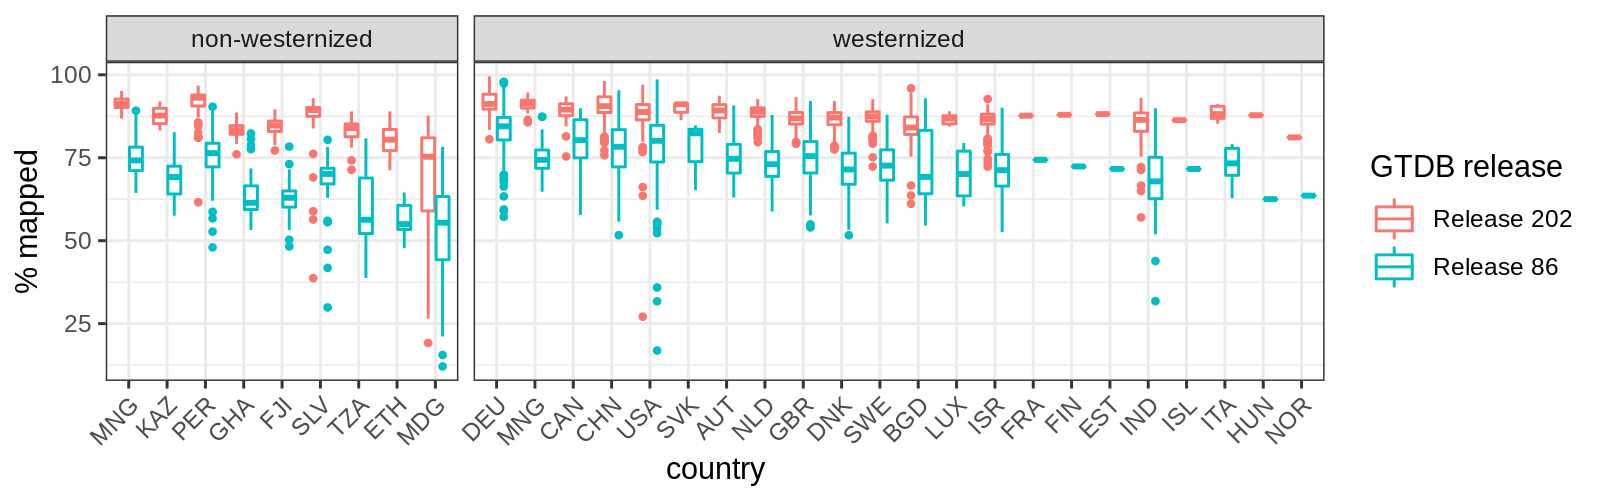

In [65]:
# summary
p = uncls %>%
    mutate.(westernized = ifelse(westernized==TRUE, 'westernized', 'non-westernized')) %>%
    mutate.(median_mapped = median(perc_mapped),
            .by=c(country)) %>%
    mutate.(country = reorder(country, -median_mapped)) %>%
    ggplot(aes(country, perc_mapped, color=database)) +
    geom_boxplot(outlier.size=0.8) +
    facet_grid(. ~ westernized, scales='free_x', space='free_x') +
    scale_color_discrete('GTDB release') +
    labs(y='% mapped') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )
p.dims(8,2.5)
plot(p)

# sessionInfo

In [37]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Anxiety_Twins_Metagenomes/envs/tidyverse-ecoPhy3/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] LeyLabRMisc_0.1.9 tidytable_0.6.3   data.table_1.14.0 ggplot2_3.3.5    
[5] tidyr_1.1.3       dplyr_1.0.7      

loaded via a namespace (and not attached):
 [1] pillar_1.6.1      compiler_4.1.0    base64enc_0.1-3   tools_4.1.0      
 [5] digest_0.6.27     uuid_0.1-4 